In [91]:
%load_ext autoreload
%autoreload 

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d.io import get_tif_tag
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

In [96]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'SS003',
    'date' :          '2024-08-15',
    'expnum' :         [1,2,3,4],}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False, get_si_params=False)
vol_rate = get_tif_tag(tifs[0],'SI.hRoiManager.scanVolumeRate')

In [97]:
job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 7,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0, 1,2,3,4,5,6]),
    # number of files to use for the initial pass
    'n_init_files' :   1,

    # volume rate in acquisition
    'fs' : vol_rate,
    'lbm' : False,
    'subtract_crosstalk' : False,
    'fuse_strips' : False,
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : False,
    'gpu_reg' : True,
}


savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4 already exists
Loading job directory for SS003_2024-08-15_1-2-3-4 in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param n_ch_tif
      Updating param planes
      Updating param n_init_files
      Updating param fs
      Updating param lbm
      Updating param subtract_crosstalk
      Updating param fuse_strips
      Updating param 3d_reg
      Updating param gpu_reg
   Updated main params file


In [98]:
raw_dir = job.make_new_dir('raw')

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/raw
      Updating self.dirs tag raw


In [103]:
import tifffile


In [130]:
raw_dir

'/mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/raw'

In [ ]:
n_planes_in_tif = 7
full_mov = []
raw_mov = []
leftover_frames = None
for idx,tif_path in enumerate(tifs):
    dir_name = tif_path.split(os.path.sep)[-2]
    tif_name = tif_path.split(os.path.sep)[-1]
    savedir = os.path.join(raw_dir, dir_name)
    os.makedirs(savedir,exist_ok=True)
    # if dir_name != '1':
        # break
    mov = tifffile.imread(tif_path)
    raw_mov.append(mov)
    print(f"Loaded tiff with {mov.shape[0]} frames: {dir_name}/{tif_name}")
    if leftover_frames is not None:
        mov = n.concatenate([leftover_frames, mov], axis=0)
        print(f"  concatenated with {leftover_frames.shape[0]} frames for a total of {mov.shape[0]} frames")
    nf, ny, nx = mov.shape
    n_full_frames = nf // n_planes_in_tif
    n_full_frame_planes = n_full_frames * n_planes_in_tif

    leftover_planes = nf % n_planes_in_tif

    full_frames = mov[:n_full_frame_planes].reshape(n_full_frames, n_planes_in_tif, ny, nx)
    leftover_frames = mov[n_full_frame_planes:]

    print(f"Full frames: {full_frames.shape} \t\t{n_full_frames} * {n_planes_in_tif} = {n_full_frame_planes}")
    print(f"Leftovers: {leftover_frames.shape}")
    print()
    n.save(os.path.join(savedir, tif_name), full_frames)
    
#     full_mov.append(full_frames)

# raw_mov = n.concatenate(raw_mov)
# full_mov = n.concatenate(full_mov)

Loaded tiff with 2000 frames: 1/2024-08-15_1_SS003_2P_00001_00001.tif
Full frames: (285, 7, 512, 512) 		285 * 7 = 1995
Leftovers: (5, 512, 512)

Loaded tiff with 2000 frames: 1/2024-08-15_1_SS003_2P_00001_00002.tif
  concatenated with 5 frames for a total of 2005 frames
Full frames: (286, 7, 512, 512) 		286 * 7 = 2002
Leftovers: (3, 512, 512)

Loaded tiff with 2000 frames: 1/2024-08-15_1_SS003_2P_00001_00003.tif
  concatenated with 3 frames for a total of 2003 frames
Full frames: (286, 7, 512, 512) 		286 * 7 = 2002
Leftovers: (1, 512, 512)

Loaded tiff with 2000 frames: 1/2024-08-15_1_SS003_2P_00001_00004.tif
  concatenated with 1 frames for a total of 2001 frames
Full frames: (285, 7, 512, 512) 		285 * 7 = 1995
Leftovers: (6, 512, 512)

Loaded tiff with 2000 frames: 1/2024-08-15_1_SS003_2P_00001_00005.tif
  concatenated with 6 frames for a total of 2006 frames
Full frames: (286, 7, 512, 512) 		286 * 7 = 2002
Leftovers: (4, 512, 512)

Loaded tiff with 2000 frames: 1/2024-08-15_1_SS003_

In [117]:
nt_raw = raw_mov.shape[0] // n_planes_in_tif

In [119]:
raw_mov = raw_mov[:nt_raw * n_planes_in_tif].reshape(nt_raw, n_planes_in_tif, ny,nx)

In [124]:
im0 = full_mov[:100].mean(axis=0)
im1 = full_mov[300:400].mean(axis=0)
im2 = full_mov[800:900].mean(axis=0)

In [76]:
mov = tifffile.imread(tifs[0])

In [77]:
mov.shape

(2000, 512, 512)

In [75]:
len(tf.pages)

2000

In [81]:
from suite3d.io.s3dio import s3dio

io = s3dio(job)

In [82]:
mov = io.load_data(paths = tifs[:1])

      Loading tiff 1/1: /mnt/zortex-subjects/SS003/2024-08-15/1/2024-08-15_1_SS003_2P_00001_00001.tif
   Standard 2P Warning: number of planes does not divide into number of tiff images, dropping 5 frames
   Loaded 1 files, total 0.97 GB


In [84]:
mov.shape

(7, 285, 512, 512)

In [79]:
mov.shape

(2000, 512, 512)

In [85]:
285*7

1995

In [51]:
job.params['voxel_size_um'] = (20, 3.0, 3.0)

   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/summary/summary.npy
   Loading init tifs with 7 channels
      Loading tiff 1/1: /mnt/zortex-subjects/SS003/2024-08-15/3/2024-08-15_3_SS003_2P_00001_00008.tif
   Standard 2P Warning: number of planes does not divide into number of tiff images, dropping 5 frames
   Loaded 1 files, total 0.97 GB
   Loaded movie with 285 frames and shape 7, 512, 512
      Enforcing positivity in mean image
   No crosstalk estimation or subtraction
   Using 2d registration
            Loaded mov and masks to GPU for rigid reg in 0.09 sec
            Allocating memory for shifted movie
            GPU RAM: 4 blocks allocated, 0.47 / 0.74 GB used
            Registering plane 0
            Shifting plane 0
            Registering plane 1
            Shifting plane 1
            Registering plane 2
            Shifting p

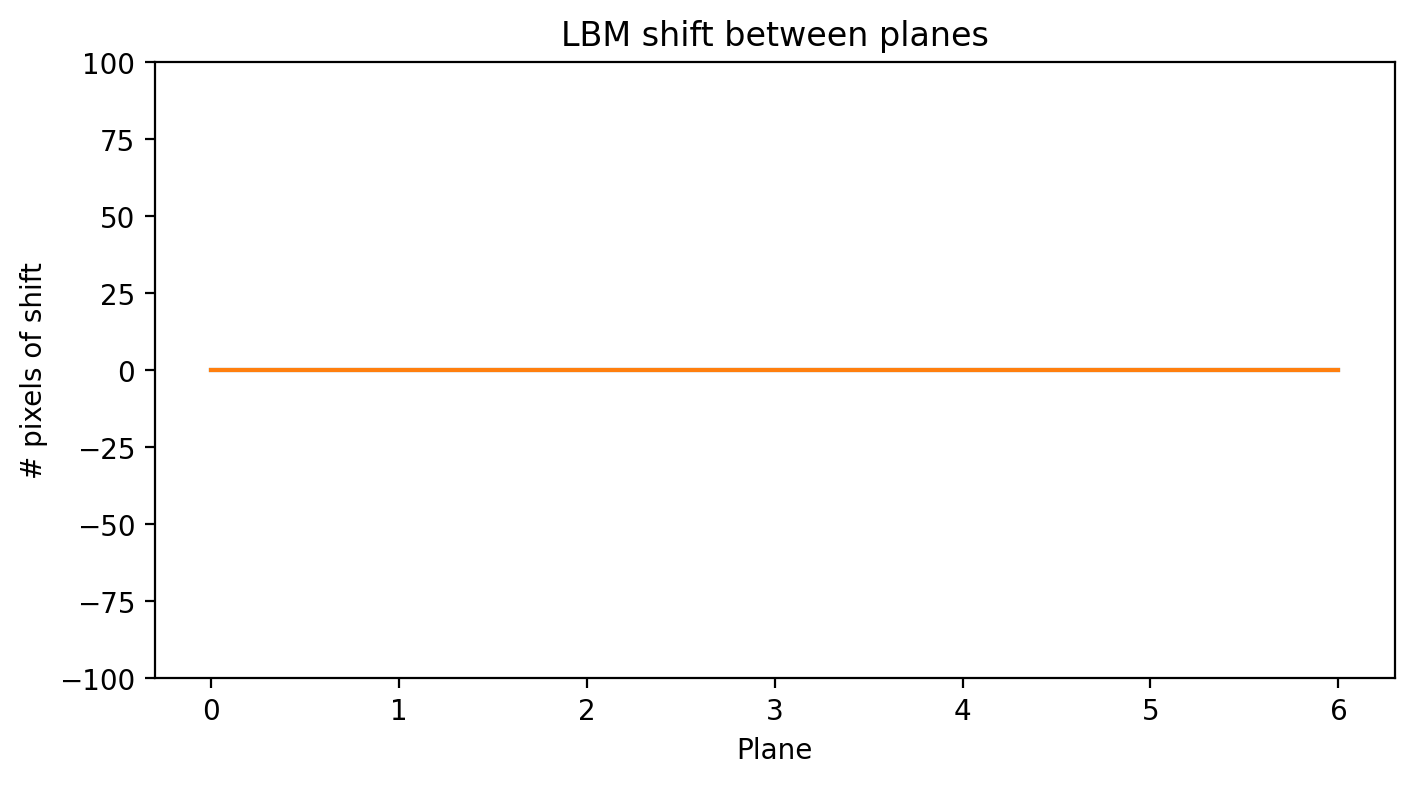

In [52]:
job.run_init_pass()

In [53]:
img3d = job.load_summary()['ref_img_3d']

In [61]:
tifs[0]

'/mnt/zortex-subjects/SS003/2024-08-15/1/2024-08-15_1_SS003_2P_00001_00001.tif'

In [62]:
im0 = io.load_data(tifs[:1])
im2 = io.load_data(tifs[1:2])

      Loading tiff 1/1: /mnt/zortex-subjects/SS003/2024-08-15/1/2024-08-15_1_SS003_2P_00001_00001.tif
   Standard 2P Warning: number of planes does not divide into number of tiff images, dropping 5 frames
   Loaded 1 files, total 0.97 GB
      Loading tiff 1/1: /mnt/zortex-subjects/SS003/2024-08-15/1/2024-08-15_1_SS003_2P_00001_00002.tif
   Standard 2P Warning: number of planes does not divide into number of tiff images, dropping 5 frames
   Loaded 1 files, total 0.97 GB


In [64]:
mean0 = im0.mean(axis=1)
mean1 = im2.mean(axis=1)

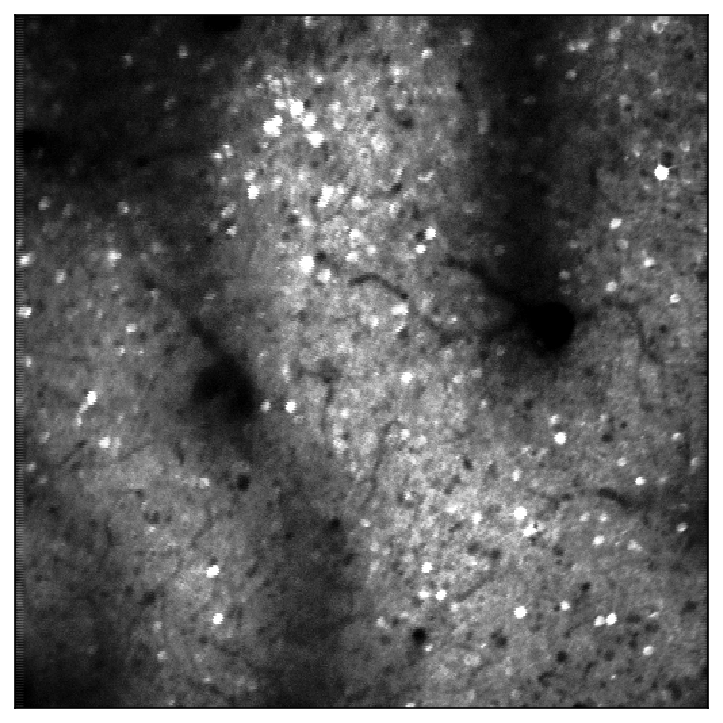

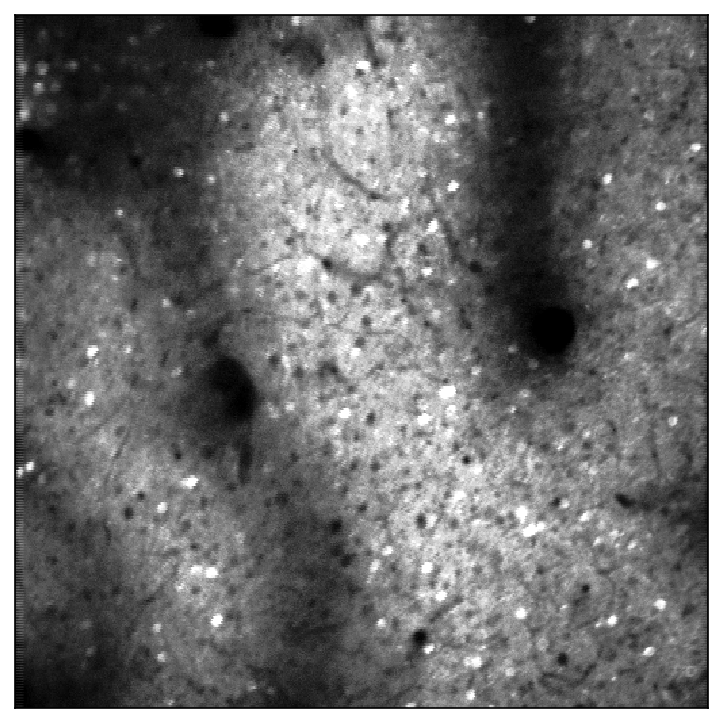

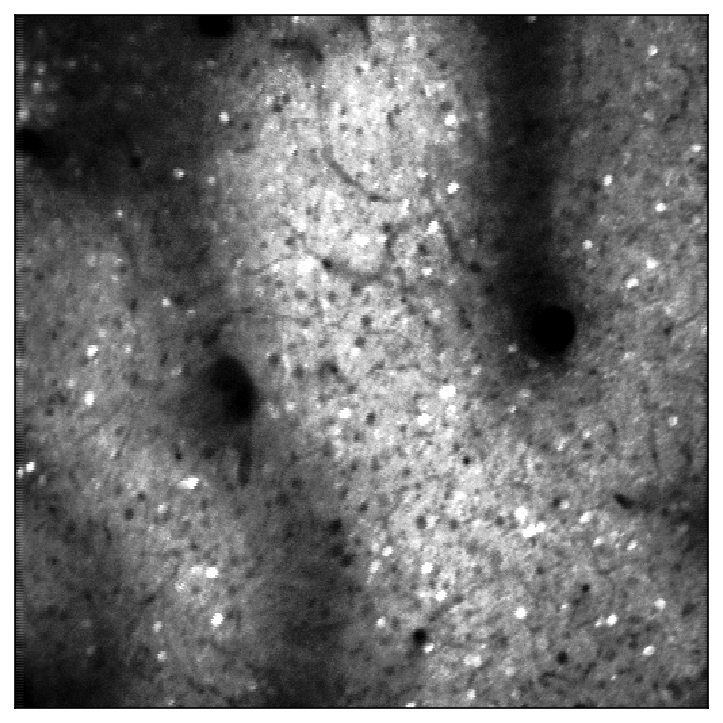

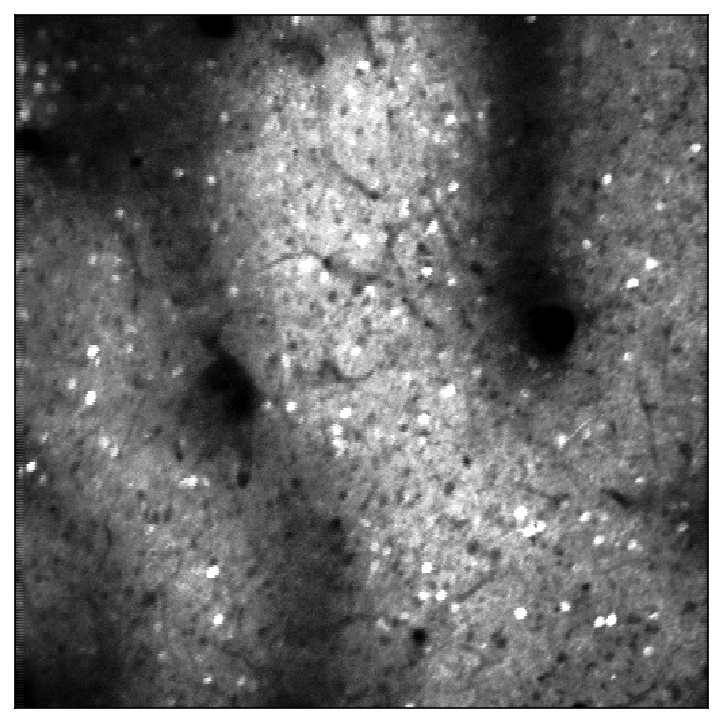

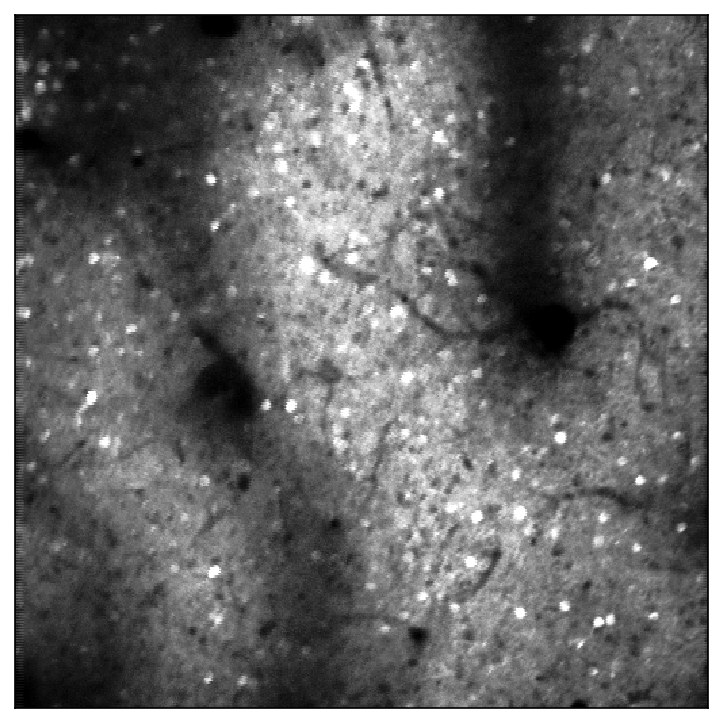

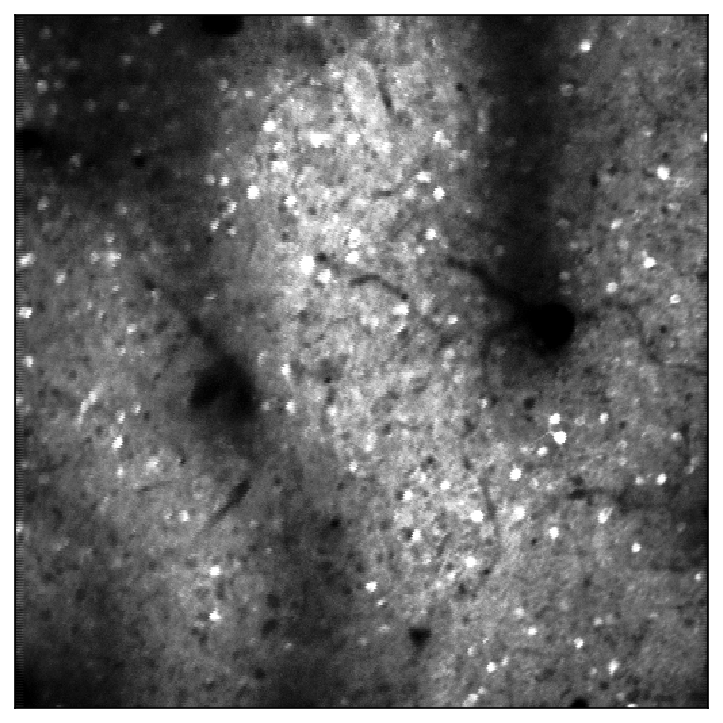

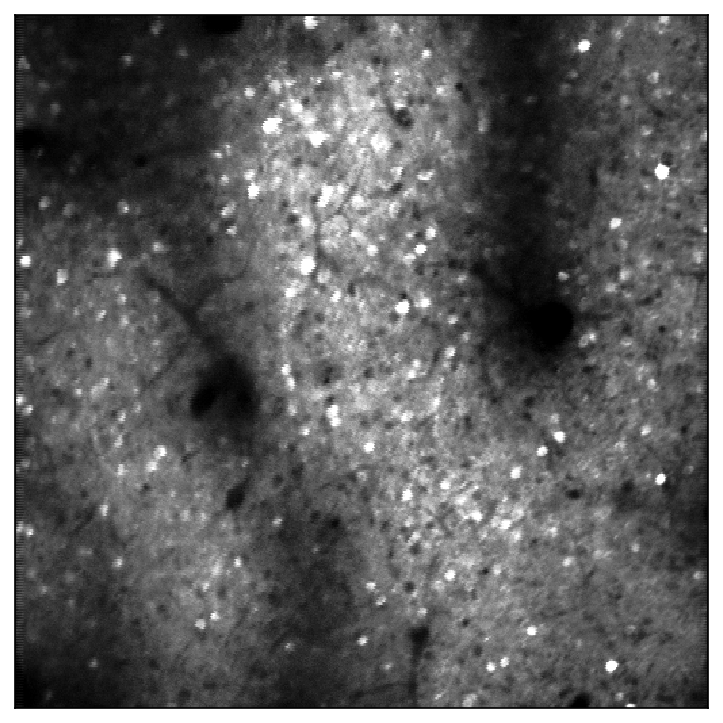

In [67]:
for i in range(img3d.shape[0]):
    tfu.show_tif(mean0[i])
    # tfu.show_tif(mean1[i])

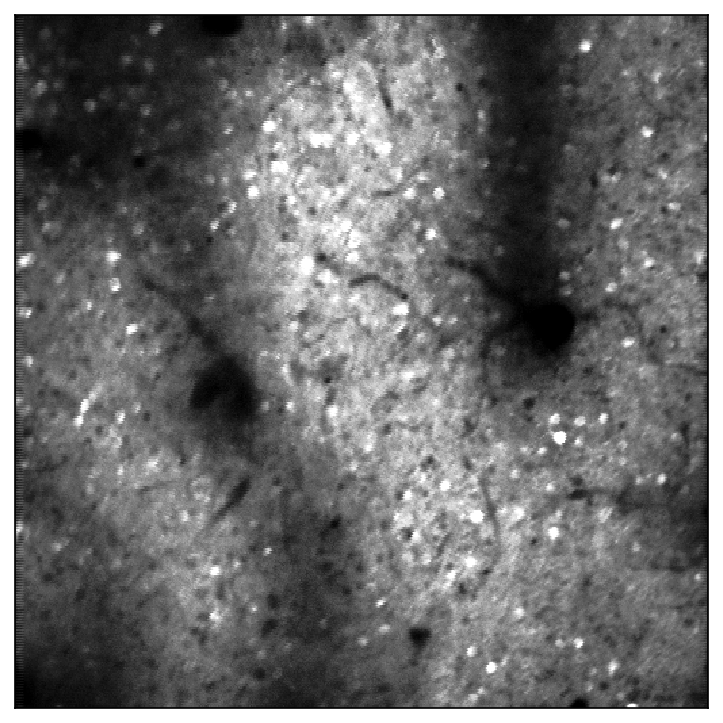

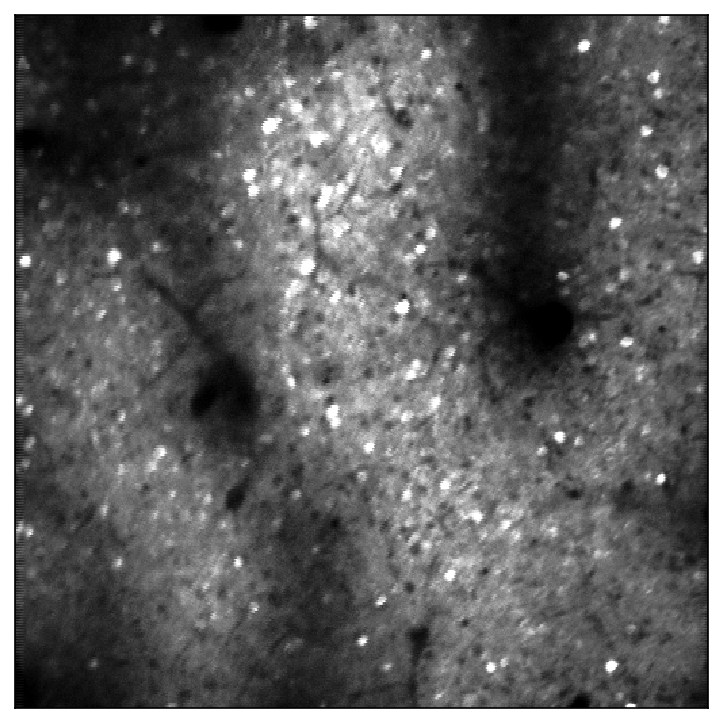

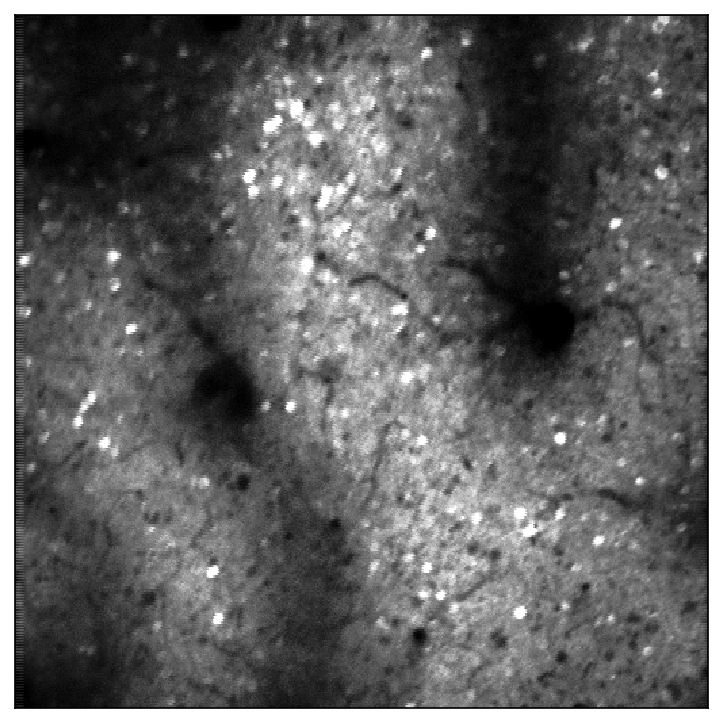

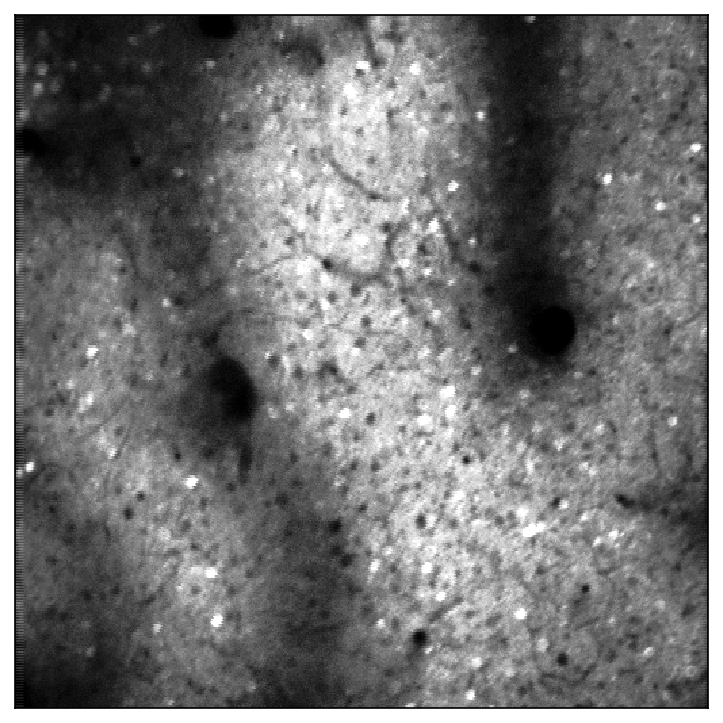

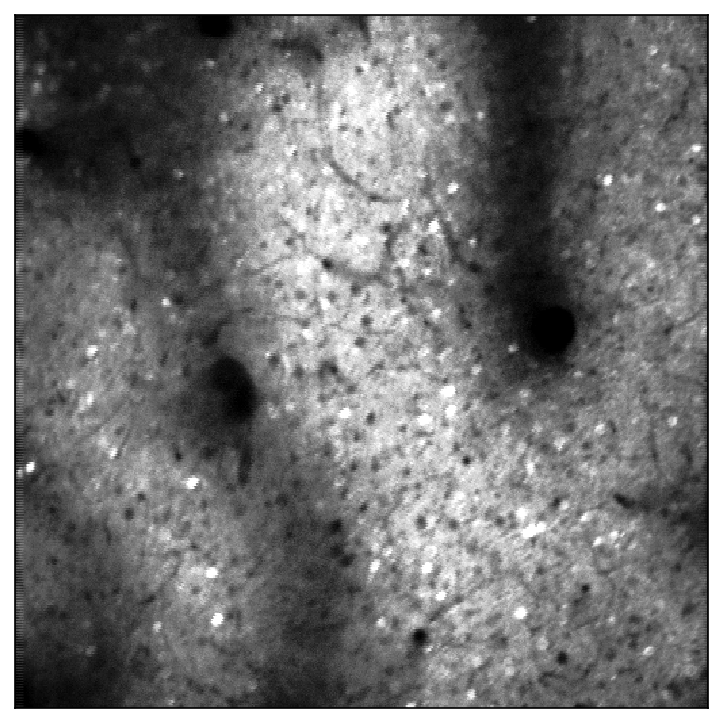

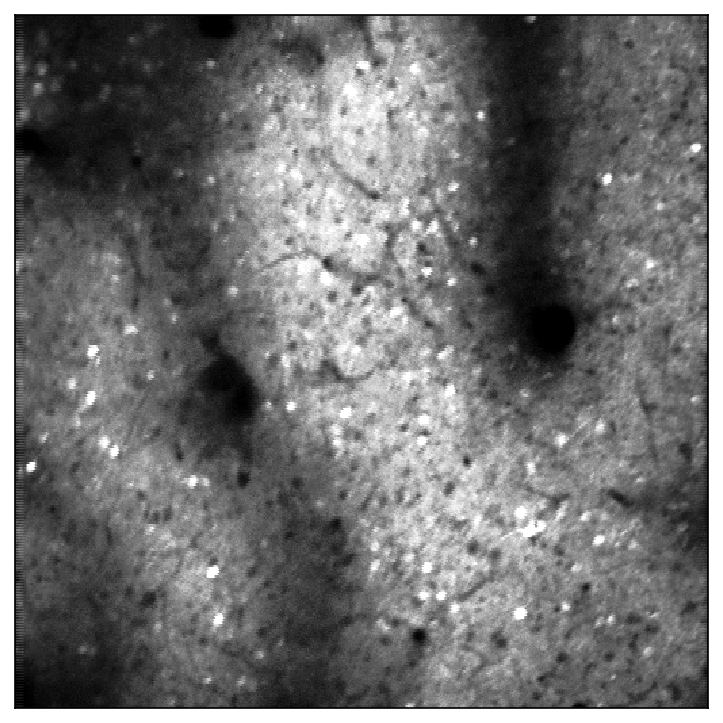

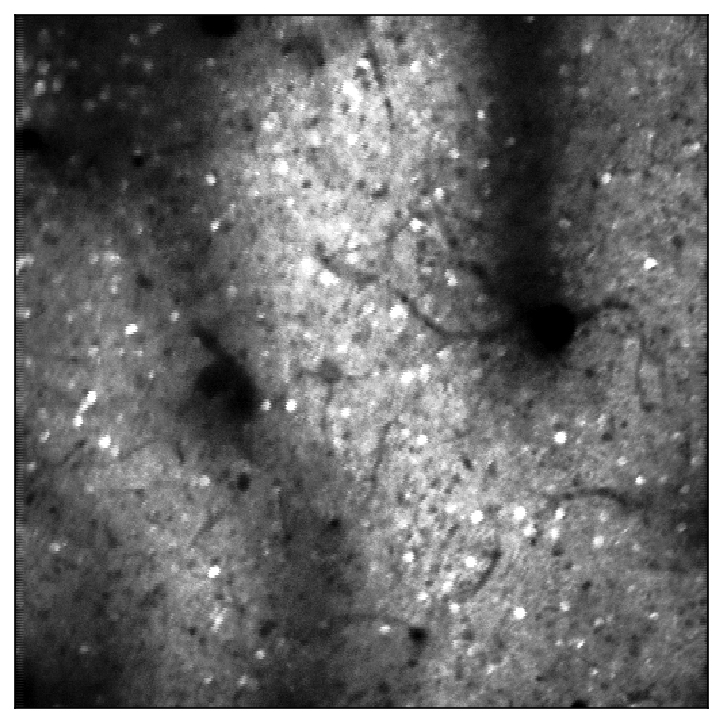

In [66]:
for i in range(img3d.shape[0]):
    # tfu.show_tif(mean0[i])
    tfu.show_tif(mean1[i])

In [ ]:
%%time
job.register(tifs=job.tifs)